### gpu inference with Efficientnet_v2

In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support as prf

In [3]:
from PIL import Image, ExifTags, ImageOps, ImageDraw
from src import bbox2tlbr, sqrbbox, compute_IoU

### data

In [4]:
df = pd.read_csv('../data/test/phase2_test.csv')
len(df)

2763

In [5]:
df.class_label.value_counts()

class_label
albopictus            1202
culex                 1127
japonicus-koreicus     232
culiseta               159
anopheles               33
aegypti                 10
Name: count, dtype: int64

### model

In [6]:
import torch
from torchvision import transforms
_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
model = torch.load('../stage1/classifier.pth').to(_device).eval()

### inference

In [8]:
_imgRoot = '../data/test/images/'
_classes = ['aegypti', 'albopictus', 'anopheles', 'culex', 'culiseta', 'japonicus-koreicus', '??']
_imgSize = 512
_imgNorm = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#_imgNorm = ([0.61800831, 0.57129184, 0.52785762], [0.07639834, 0.08574163, 0.09442848])

In [9]:
transform = transforms.Compose([
    transforms.Resize((_imgSize, _imgSize)),
    transforms.ToTensor(),
    transforms.Normalize(_imgNorm[0], _imgNorm[1])
])

In [10]:
def predict(row):
    
    # open image file
    pilImg = Image.open('%s/%s' %(_imgRoot, row.img_fName))
    
    # crop image
    bbox = sqrbbox([(row.bbx_xtl, row.bbx_ytl), (row.bbx_xbr, row.bbx_ybr)], pilImg.size)
    pilImg = pilImg.crop(bbox)
    
    # transform to torch tensor image
    torchImg = torch.unsqueeze(transform(pilImg), dim = 0).to(_device)
    
    # inference
    output = model(torchImg)
    
    # scores
    output = torch.nn.functional.softmax(output, dim = 1)
    scores = output.cpu().detach().numpy()[0]
    
    # get class predictions
    pred = {k:s for k, s in zip(_classes, scores)}
    pred['img_fName'] = row.img_fName
    pred['pred_label'] = _classes[np.argmax(scores)]
    
    return pred

In [11]:
%%time
outputs = df.apply(predict, axis = 1)

/home/jgarriga/miniconda3/envs/ma24/lib/python3.10/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


CPU times: user 1h 40min 44s, sys: 16min 52s, total: 1h 57min 36s
Wall time: 11min 36s


In [12]:
df_ = pd.merge(df, pd.DataFrame([output for output in outputs]), how = 'inner', on = 'img_fName')

In [13]:
df_.groupby('class_label').pred_label.value_counts()

class_label         pred_label        
aegypti             aegypti                  7
                    albopictus               1
                    culex                    1
                    culiseta                 1
albopictus          albopictus            1168
                    ??                      12
                    japonicus-koreicus       8
                    aegypti                  6
                    culex                    6
                    culiseta                 2
anopheles           anopheles               27
                    culex                    3
                    culiseta                 3
culex               culex                 1102
                    culiseta                10
                    ??                       9
                    anopheles                4
                    aegypti                  1
                    albopictus               1
culiseta            culiseta               142
                    c

#### Classification

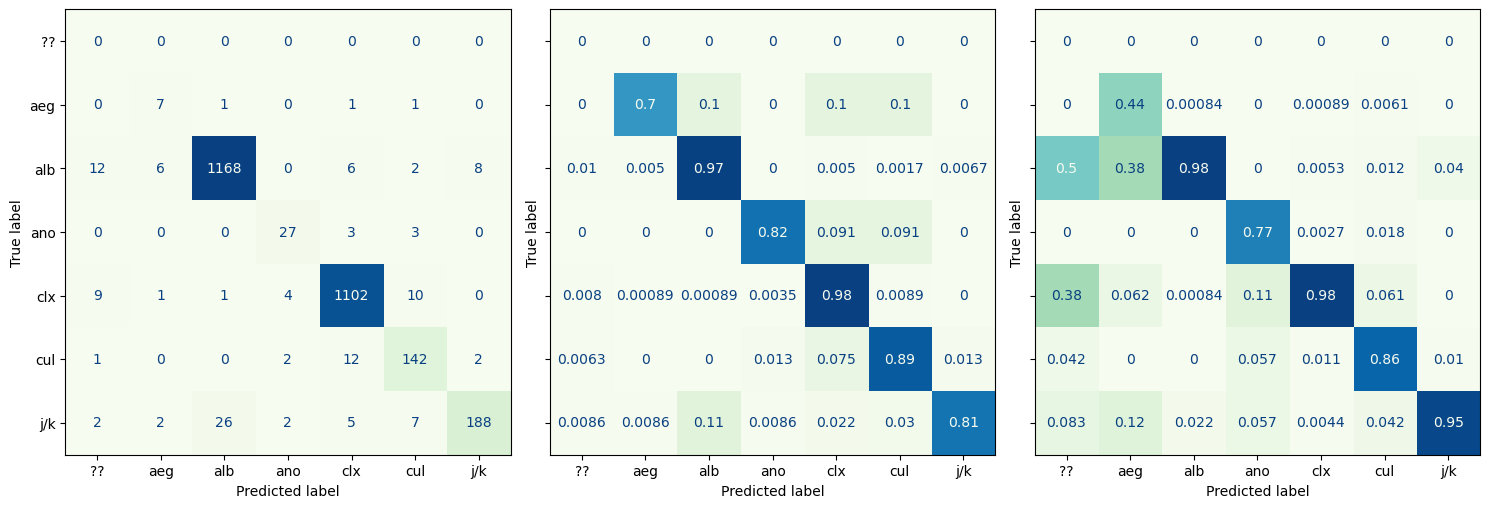

In [14]:
_, axs = plt.subplots(1, 3, figsize = (15, 7), sharey = True)
for i, norm in enumerate([None, 'true', 'pred']):
    ConfusionMatrixDisplay.from_predictions(
        df_.class_label,
        df_.pred_label,
        normalize = norm,
        ax = axs[i],
        display_labels = ['??', 'aeg', 'alb', 'ano', 'clx', 'cul', 'j/k'],
        cmap = 'GnBu',
        colorbar = None
    )
plt.tight_layout()

In [15]:
avrgs = ['macro', 'micro', 'weighted']
pd.DataFrame([prf(df_.class_label, df_.pred_label, average = mode, zero_division = 0)[:3] for mode in avrgs], columns = ['precision', 'recall', 'f-score'], index = avrgs)

,precision,recall,f-score
macro,0.710243,0.738734,0.719234
micro,0.953312,0.953312,0.953312
weighted,0.963032,0.953312,0.957572


#### check predictions

In [16]:
i = -1

+++  0 test_00000.jpeg - culex / culex


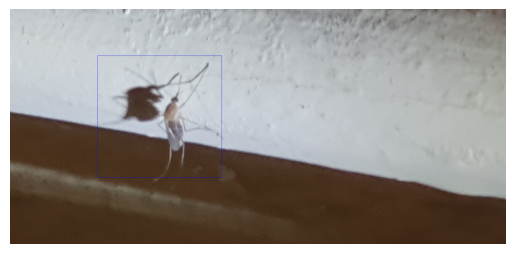

In [17]:
i += 1
row = df_.iloc[i]
pilImg = Image.open('%s/%s' %(_imgRoot, row.img_fName))
imgdrw = ImageDraw.Draw(pilImg)
imgdrw.rectangle([(row.bbx_xtl, row.bbx_ytl), (row.bbx_xbr, row.bbx_ybr)], outline = 'blue', width = 2)
plt.imshow(pilImg)
plt.axis('off');
print('+++%3d %s - %s / %s' %(i, row.img_fName, row.class_label, row.pred_label))

+++185 - albopictus / ??


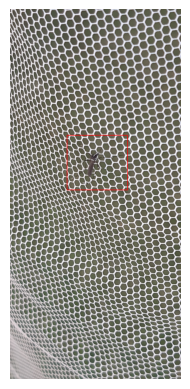

In [18]:
i = 185#, 202, 343
row = df_.iloc[i]
pilImg = Image.open('%s/%s' %(_imgRoot, row.img_fName))
imgdrw = ImageDraw.Draw(pilImg)
imgdrw.rectangle([(row.bbx_xtl, row.bbx_ytl), (row.bbx_xbr, row.bbx_ybr)], outline = 'red', width = 8)
plt.imshow(pilImg)
plt.axis('off');
print('+++%3d - %s / %s' %(i, row.class_label, row.pred_label))